# Reading Insights

## A deeper look into my reading behavior and habits

January 2018

This project scratches the surface of an analysis of my past reading behaviors and habits. Please refer to the overview notebook for complete information about my objectives and motivations. In brief, through this project I wish to (1) improve my understanding of data analysis and data analysis methodologies, (2) quantify and objectify the materials I like to read, and (3) create a model capable of predicting the degree to which I may enjoy a certain book.

It's important to me that this document be readable by the average college-educated person. My goal is to include the technicalities of the analysis but preserve the accessibility of the project.

## Summary

1) I began this project with some **data preparation** by cleaning up my book collections on Goodreads.com (fixing publication years, page numbers, etc.). I first separated books into "shelves" that represented genres of various specificities. I gave each book the best start and finish date I could. I re-rated some of my older books to represent how I feel about them now. I manually added features (columns in my spreadsheet) which are prefixed with "inf_" and these will be explained later.

2) After exporting my Goodreads data, I pulled it into a Pandas dataframe (simply a 2-dimensional matrix, with rows and labeled columns). From here, descriptive statistics could be extracted from the data set easily. **Data visualization** will be expanded and is important for those unfamiliar with the data set and its characteristics. TODO: Develop coverage of inferential statistics.

3) I am currently implementing an entity keyword extraction (explained later, but this means the computer is searching for words/phrases that are highly relevant to the author) method using IBM's Watson Developer Cloud to expand the feature range (the number of characteristics/columns of each book). A large amount of noise is a side effect of this and I am working to minimize this, thus I have not implemented this in the final problem yet.

4) I **preprocess** my data set and transform it into a compressed sparse row matrix due to the number of binary features (in other words, I transform my data set into a format that is faster and more efficient for the computer to manipulate). I attempt several scaling and normalization techniques (for example, tranforming the original publication year from a range of -390 to 2016 to something much smaller with a mean of say 0). I then compare and visualize these transformations.

5) The final portion of this project now begins. The idea behind the next few steps is to find a classification algorithm using scikit-learn that can best (without overfitting or generalizing) classify a book into a 1-5 star rating. I find this classifier by searching over multiple algorithms with multiple data tranformations and multiple paramters for each classifier (parameters tune how the algorithm behaves).

6) I compare the results of this GridSearch, and those results are discussed below.

## Analysis

Import the required libraries (these are other pieces of code I did not write that my project relies on).

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import sys

from scipy import sparse
from scipy.stats import stats


import wikipedia
from wikipedia import DisambiguationError

from watson_developer_cloud import NaturalLanguageUnderstandingV1
from watson_developer_cloud.natural_language_understanding_v1 import Features, ConceptsOptions

import matplotlib.pyplot as plt
import seaborn as sns

from itertools import chain

from fuzzywuzzy import fuzz

from sklearn import preprocessing
from sklearn.decomposition import KernelPCA, TruncatedSVD
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import make_scorer

Set the style for future visualizations and charts.

In [2]:
sns.set_style('darkgrid')

Authenticate my code to use IBM's Developer Cloud API.

In [3]:
ibm_creds = {
  "url": "https://gateway.watsonplatform.net/natural-language-understanding/api",
  "username": "bb7a01e4-be21-44f1-83a3-2c316cf57d73",
  "password": ""
}
natural_language_understanding = NaturalLanguageUnderstandingV1(
  username=ibm_creds['username'],
  password=ibm_creds['password'],
  version='2017-02-27')

Import my Excel spreadsheet that contains my Goodreads data.

I have 37 characteristics for each of my 51 books.

Features (columns) that are prefixed with `inf_` denote a binary (0 for false, 1 for true) characteristic which represents the author's major geographic and cultural influence. For example, an author born and raised in America would be tagged with `inf_north_amer1`. An author raised in America, but with, say Indian parents, whose writing is influenced by Indian culture would be tagged as `inf_north_amer1` and `inf_asia`.

`rating` is my rating of the book, 1-5. `agg_rating` is the average aggregate rating on Goodreads. `duration` is in days. Features prefixed by `is_` denote the genre.

In [4]:
data = pd.read_excel('/Users/alex/Documents/ReadingInsights/library_export.xlsx')
print(data.shape)
print(data.dtypes)
print(data.head())

(51, 37)
book_id                            int64
title                             object
author                            object
inf_north_amer                     int64
inf_south_central_amer             int64
inf_asia                           int64
inf_middle_east                    int64
inf_west_europe                    int64
inf_east_europe                    int64
inf_africa                         int64
inf_oceania                        int64
is_female                          int64
isbn13                           float64
rating                             int64
agg_rating                       float64
pages                              int64
pub_year                           int64
org_pub_year                       int64
finished                  datetime64[ns]
started                   datetime64[ns]
duration                           int64
is_fiction                         int64
is_nonfiction                      int64
is_adventure                       int64
is_biog

**Begin: Entity Keyword Extraction, a work in-progress not implemented in final problem**

I iterate over each unique author and extract the url for their Wikipedia page.

In [15]:
authors = data['author']
author_url = {}
try:
    for author in set(authors):
        author_url[author] = wikipedia.page(author).url
except DisambiguationError as err:
    print(err)
    
list(author_url.values())[:5]

['https://en.wikipedia.org/wiki/Epictetus',
 'https://en.wikipedia.org/wiki/Paul_Krugman',
 'https://en.wikipedia.org/wiki/Tom_Shroder',
 'https://en.wikipedia.org/wiki/John_Steinbeck',
 'https://en.wikipedia.org/wiki/Czes%C5%82aw_Mi%C5%82osz']

Manually adjust some bad results. This noise must be automatically adjusted for in a final implementation.

In [16]:
author_url['Jim Afremow'] = 'http://www.goldmedalmind.net/about-dr-jim/'
author_url['Stefan Hildebrandt'] = 'http://worldcat.org/identities/lccn-n80054555/'
author_url['Russell Wild'] = 'https://www.napfa.org/member/5511/3203'

For each author's Wikipedia page, extract 8 entity keywords.

In [13]:
concepts = {}
for author in author_url:
    response = natural_language_understanding.analyze(
      url=author_url[author],
        language='en',
      features=Features(
        concepts=ConceptsOptions(
        limit=8)))
    concepts[author] = []
    for concept in response['concepts']:
        concepts[author].append(concept['text'])
        

WatsonApiException: Error: attempt to fetch failed: :closed, Code: 400

Simplify the entity list to keep only significant and non-unique entries.

In [98]:
mixed_concepts = list(chain.from_iterable(concepts.values()))

def find_similarities(arr):
    simplified_concepts = []
    
    for first in arr:
        for second in arr:
            simplest = min([first, second], key=len)
            if first is not second and fuzz.partial_ratio(first, second) > 85 and simplest not in simplified_concepts:
                #print((first, second, simplest))
                simplified_concepts.append(simplest)
                
    return simplified_concepts

a = find_similarities(mixed_concepts)
final_concepts = find_similarities(a)

**End**

Separate data set into distinct subsets which can be usefully manipulated. Our algorithms only accept numeric data, so I remove the text type columns.

In [10]:
data_object = data[['title', 'author', 'finished', 'started']]
data_influences = data[['inf_north_amer', 'inf_south_central_amer', 'inf_asia', 'inf_middle_east',
                        'inf_west_europe', 'inf_east_europe', 'inf_africa', 'inf_oceania']]
data_genres = data[['is_fiction', 'is_nonfiction', 'is_adventure', 'is_biography', 'is_drama',
                    'is_expository', 'is_historical_ficition', 'is_memoir', 'is_philosophy',
                    'is_poetry', 'is_political_science', 'is_realistic_fiction',
                    'is_religion', 'is_science', 'is_sci_fi', 'is_short_story']]
data_numeric = pd.concat([
    data_influences,
    data_genres,
    data[['is_female', 'agg_rating', 'pages', 'pub_year',
          'org_pub_year', 'duration']]
], axis=1)
target = data[['rating']]

Describe each column with basic measures of central tendency, dispersion, and a sum. Some descriptors are useless for certain features.

57% of authors I read are influenced by North American culture, with a low at only 2% from Oceanic culture (Australia). 55% of my books are fiction, 27% are labeled as science.

12% of my authors are female, which only strengthens the assumptions that I could diversify my authors more.

I rate the books I've read about half a star lower than what other Goodreads users rate the same books (4.00 - 3.55). On average, I take 18 days to finish a book, which on average is 236 pages. More than half of the books I read were originally published before 1996.

In [11]:
print('Minimum\tMaximum\tMean\tMedian\tSum\n')

for col in pd.concat([data_numeric, target], axis=1):
    print('{}\n{:.2f}\t{:.2f}\t{:.2f}\t{:.2f}\t{}\n'.format(
        col, 
        data[col].min(), 
        data[col].max(), 
        data[col].mean(), 
        data[col].median(), 
        data[col].sum()))

Minimum	Maximum	Mean	Median	Sum

inf_north_amer
0.00	1.00	0.57	1.00	29

inf_south_central_amer
0.00	1.00	0.02	0.00	1

inf_asia
0.00	1.00	0.12	0.00	6

inf_middle_east
0.00	1.00	0.04	0.00	2

inf_west_europe
0.00	1.00	0.33	0.00	17

inf_east_europe
0.00	1.00	0.06	0.00	3

inf_africa
0.00	1.00	0.06	0.00	3

inf_oceania
0.00	1.00	0.02	0.00	1

is_fiction
0.00	1.00	0.55	1.00	28

is_nonfiction
0.00	1.00	0.45	0.00	23

is_adventure
0.00	1.00	0.10	0.00	5

is_biography
0.00	1.00	0.02	0.00	1

is_drama
0.00	1.00	0.02	0.00	1

is_expository
0.00	1.00	0.20	0.00	10

is_historical_ficition
0.00	1.00	0.14	0.00	7

is_memoir
0.00	1.00	0.12	0.00	6

is_philosophy
0.00	1.00	0.20	0.00	10

is_poetry
0.00	1.00	0.08	0.00	4

is_political_science
0.00	1.00	0.06	0.00	3

is_realistic_fiction
0.00	1.00	0.20	0.00	10

is_religion
0.00	1.00	0.06	0.00	3

is_science
0.00	1.00	0.27	0.00	14

is_sci_fi
0.00	1.00	0.08	0.00	4

is_short_story
0.00	1.00	0.06	0.00	3

is_female
0.00	1.00	0.12	0.00	6

agg_rating
3.17	4.50	4.00	4.00	204.

12344
(51, 30)


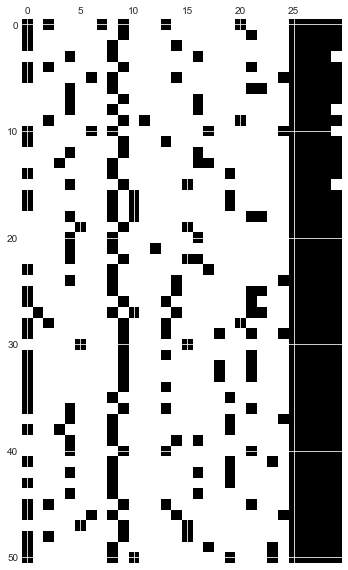

float64
56


In [17]:
print(sys.getsizeof(data_numeric))
print(data_numeric.shape)

data_numeric.fillna(0, inplace=True)

plt.figure(figsize=(6,10))
plt.spy(data_numeric)
plt.show()

data_numeric['org_pub_year'] -= min(data_numeric['org_pub_year']) - 1

sparse_data_numeric = sparse.csr_matrix(data_numeric)

print(sparse_data_numeric.dtype)
print(sys.getsizeof(sparse_data_numeric))

In [18]:
scaled_sparse_data_numeric = preprocessing.scale(sparse_data_numeric, with_mean=False)

quantile_trans_sparse_data_numeric = preprocessing.quantile_transform(
    sparse_data_numeric,
    output_distribution='normal')

normal_sparse_data_matrix = preprocessing.normalize(sparse_data_numeric)

In [19]:
def find_correlation(df, thresh=0.9):
    """
    Given a numeric pd.DataFrame, this will find highly correlated features,
    and return a list of features to remove
    params:
    - df : pd.DataFrame
    - thresh : correlation threshold, will remove one of pairs of features with
               a correlation greater than this value
               
    Created by Scott Warchal
    https://gist.github.com/Swarchal/881976176aaeb21e8e8df486903e99d6
    """
    
    corrMatrix = df.corr()
    corrMatrix.loc[:,:] =  np.tril(corrMatrix, k=-1)

    already_in = set()
    result = []

    for col in corrMatrix:
        perfect_corr = corrMatrix[col][corrMatrix[col] > thresh].index.tolist()
        if perfect_corr and col not in already_in:
            already_in.update(set(perfect_corr))
            perfect_corr.append(col)
            result.append(perfect_corr)


    select_nested = [f[1:] for f in result]
    select_flat = [i for j in select_nested for i in j]
    return select_flat

find_correlation(data_numeric, 0.7)

[]

[ 0.53695184  0.41893296  0.04307052]
[ 0.03174465  0.24913326  0.15743499]
[ 0.11343838  0.84707205  0.03839033]


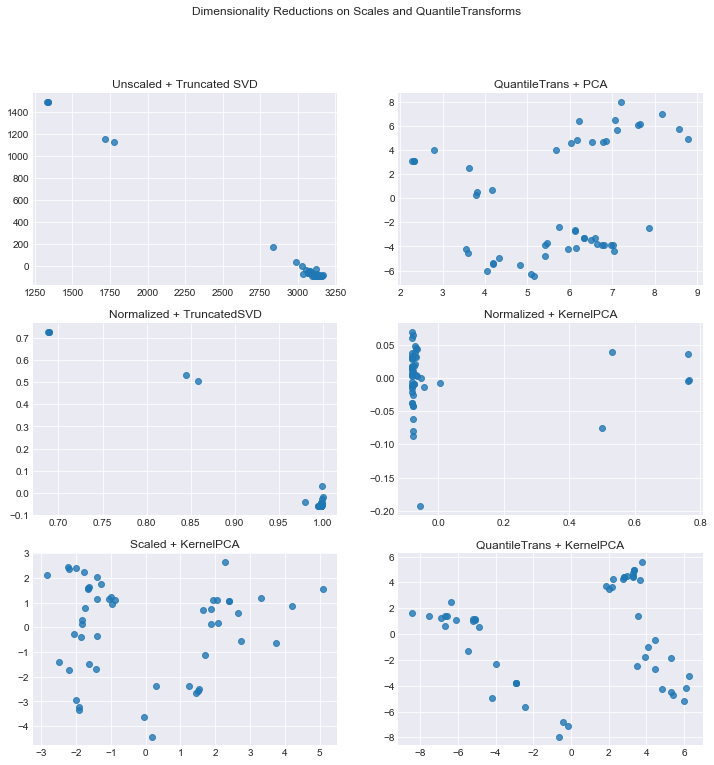

In [21]:
# https://dziganto.github.io/Sparse-Matrices-For-Efficient-Machine-Learning/

fig = plt.figure(figsize=(12,12))
fig.suptitle("Dimensionality Reductions on Scales and QuantileTransforms")

components = 3


plt.subplot(3, 2, 1)
plt.title("Unscaled + TruncatedSVD")

tsvd_decomp = TruncatedSVD(n_components=components).fit(sparse_data_numeric)
print(tsvd_decomp.explained_variance_ratio_)
tsvd_decomp = tsvd_decomp.transform(sparse_data_numeric)

a = tsvd_decomp[:,0]
b = tsvd_decomp[:,1]
sns.regplot(a,b, fit_reg=False)

plt.subplot(3, 2, 2)
plt.title("QuantileTrans + PCA")

pca_decomp = TruncatedSVD(n_components=components).fit(quantile_trans_sparse_data_numeric)
print(pca_decomp.explained_variance_ratio_)
pca_decomp = pca_decomp.transform(quantile_trans_sparse_data_numeric)

a = pca_decomp[:,0]
b = pca_decomp[:,1]
sns.regplot(a,b, fit_reg=False)

plt.subplot(3, 2, 3)
plt.title("Normalized + TruncatedSVD")

norm_tsvd_decomp = TruncatedSVD(n_components=components).fit(normal_sparse_data_matrix)
print(norm_tsvd_decomp.explained_variance_ratio_)
norm_tsvd_decomp = norm_tsvd_decomp.transform(normal_sparse_data_matrix)

a = norm_tsvd_decomp[:,0]
b = norm_tsvd_decomp[:,1]
sns.regplot(a,b, fit_reg=False)

plt.subplot(3, 2, 4)
plt.title("Normalized + KernelPCA")

norm_kpca_decomp = KernelPCA(n_components=components).fit_transform(normal_sparse_data_matrix)

a = norm_kpca_decomp[:,0]
b = norm_kpca_decomp[:,1]
sns.regplot(a,b, fit_reg=False)

plt.subplot(3, 2, 5)
plt.title("Scaled + KernelPCA")
kpca_s_decomp = KernelPCA(n_components=components).fit_transform(scaled_sparse_data_numeric)

a = kpca_s_decomp[:, 0]
b = kpca_s_decomp[:, 1]
sns.regplot(a,b,fit_reg=False)

plt.subplot(3, 2, 6)
plt.title("QuantileTrans + KernelPCA")
kpca_qt_decomp = KernelPCA(n_components=components).fit_transform(quantile_trans_sparse_data_numeric)

a = kpca_qt_decomp[:, 0]
b = kpca_qt_decomp[:, 1]
sns.regplot(a,b,fit_reg=False)

plt.show()


In [22]:
sets = {
    'Scaled_Sparse_Data': scaled_sparse_data_numeric, 
    'Scaled-TruncatedSVD': tsvd_decomp, 
    'Quantile_Transform-PCA': pca_decomp, 
    'Normalized-TruncatedSVD': norm_tsvd_decomp, 
    'Normalized-KernelPCA': norm_kpca_decomp, 
    'Scaled-KernelPCA': kpca_s_decomp, 
    'Quantile_Transform-KernelPCA': kpca_qt_decomp
}


In [27]:
models = {
    'LogisticRegression': LogisticRegression(),
    'RidgeClassifier': RidgeClassifier(),
    'SGDClassifier': SGDClassifier(),
    'KNeighborsClassifier': KNeighborsClassifier(),
    'SVC': SVC(),
    'RandomForestClassifier': RandomForestClassifier(),
    'AdaBoostClassifier': AdaBoostClassifier(),
    'MLPClassifier': MLPClassifier()
}
params = {
    'LogisticRegression': {
        'C': [0.0001, 0.001, 0.01, 0.1, 0.5, 1.],
        'penalty': ['l2', 'l1']
    },
    'RidgeClassifier': {
        'alpha': [0.0001, 0.001, 0.01, 0.1, 1., 10., 100., 500., 1000.]
    },
    'SGDClassifier': {
        'alpha': [0.0001, 0.001, 0.01, 0.1, 1., 10., 100.],
        'max_iter': [500, 1000, 2500],
        'loss': ['hinge', 'squared_hinge'],
        'penalty': ['l2', 'l1']
    },
    'KNeighborsClassifier': {
        'n_neighbors': [2, 3, 4, 6, 8, 10, 12, 14],
        'leaf_size': [2, 3, 6, 10, 20, 30]
    },
    'SVC': {
        'C': [0.000000001, 0.000001, 0.00001, 0.001, 0.01, 0.1, 0.5, 1., 2., 10.],
        'kernel': ['linear', 'rbf'],
        'gamma': ['auto', 0.1, 1., 2., 10.]
    },
    'RandomForestClassifier': {
        'max_features': ['auto', 'log2', 0.25, 0.5, 0.75, 1],
        'n_estimators': [1, 3, 5, 7, 10, 25, 50, 75, 100],
        'max_depth': [3, 5, 7, 10, 20, None]
    },
    'AdaBoostClassifier': {
        'n_estimators': [1, 3, 5, 7, 10, 25, 50, 75, 100]
    },
    'MLPClassifier': {
        'activation': ['relu', 'logistic'],
        'learning_rate_init': [1e-6, 1e-5, 1e-4],
        'max_iter': [2000, 3000, 4000],
        'solver': ['lbfgs'],
        'hidden_layer_sizes': [(25,),(23,),(21,),(19,),(17,),(15,),(13,),(11,),(9,),(7,)]
    }
}


searching

search Scaled_Sparse_Data
LogisticRegression done
RidgeClassifier done
SGDClassifier done
KNeighborsClassifier done
SVC done
RandomForestClassifier done
AdaBoostClassifier done
MLPClassifier done

search Scaled-TruncatedSVD
LogisticRegression done
RidgeClassifier done
SGDClassifier done
KNeighborsClassifier done
SVC done
RandomForestClassifier done
AdaBoostClassifier done
MLPClassifier done

search Quantile_Transform-PCA
LogisticRegression done
RidgeClassifier done
SGDClassifier done
KNeighborsClassifier done
SVC done
RandomForestClassifier done
AdaBoostClassifier done
MLPClassifier done

search Normalized-TruncatedSVD
LogisticRegression done
RidgeClassifier done
SGDClassifier done
KNeighborsClassifier done
SVC done
RandomForestClassifier done
AdaBoostClassifier done
MLPClassifier done

search Normalized-KernelPCA
LogisticRegression done
RidgeClassifier done
SGDClassifier done
KNeighborsClassifier done
SVC done
RandomForestClassifier done
AdaBoostClassifier done
MLPClassifie

In [32]:
searches = {}

print('searching')

for set in sets:
    
    X = sets[set]
    y = np.array(target).ravel()
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
    
    print('\nsearch ' + set)
    
    for key in models.keys():
        
        gs = GridSearchCV(models[key], params[key], cv=2, return_train_score=True)
        gs.fit(X_train, y_train)
        searches[set + '__' + key] = gs
        
        print(key + ' done')
        


searching

search Scaled_Sparse_Data
LogisticRegression done
RidgeClassifier done
SGDClassifier done
KNeighborsClassifier done
SVC done
RandomForestClassifier done
AdaBoostClassifier done
MLPClassifier done

search Scaled-TruncatedSVD
LogisticRegression done
RidgeClassifier done
SGDClassifier done
KNeighborsClassifier done
SVC done
RandomForestClassifier done
AdaBoostClassifier done
MLPClassifier done

search Quantile_Transform-PCA
LogisticRegression done
RidgeClassifier done
SGDClassifier done
KNeighborsClassifier done
SVC done
RandomForestClassifier done
AdaBoostClassifier done
MLPClassifier done

search Normalized-TruncatedSVD
LogisticRegression done
RidgeClassifier done
SGDClassifier done
KNeighborsClassifier done
SVC done
RandomForestClassifier done
AdaBoostClassifier done
MLPClassifier done

search Normalized-KernelPCA
LogisticRegression done
RidgeClassifier done
SGDClassifier done
KNeighborsClassifier done
SVC done
RandomForestClassifier done
AdaBoostClassifier done
MLPClassifie

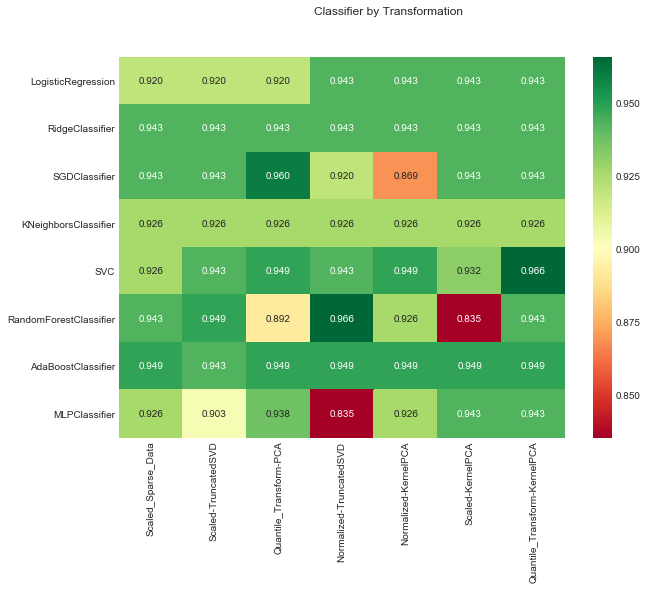

In [63]:
def mean_squared_classifier(y_true, y_pred):
    sqr_sum = 0
    for y0, y1 in zip(y_pred, y_true):
        y0 = (y0 - 1) / 4
        y1 = (y1 - 1) / 4

        sqr_sum += pow(y1 - y0, 2)

    return 1 - sqr_sum / len(y_true)

scorer = make_scorer(mean_squared_classifier, greater_is_better=True)

results = pd.DataFrame(0, index=models, columns=sets.keys())

for search in searches:

    set, model = search.split('__')

    clf = models[model]
    clf.set_params(**searches[search].best_params_)
    clf.fit(X_train, y_train)

    results.loc[model, set] += scorer(clf, X_test, y_test)

plt.figure(figsize=(10, 7))
plt.suptitle('Classifier by Transformation')
sns.heatmap(results, annot=True, fmt="0.3f", cmap='RdYlGn')


In [67]:
select = 'Quantile_Transform-PCA__SGDClassifier'

searches[select].best_params_

{'alpha': 0.0001, 'loss': 'hinge', 'max_iter': 500, 'penalty': 'l2'}

In [73]:
y = np.array(target).ravel()

set, model = select.split('__')

clf = models[model]
clf.set_params(**searches[select].best_params_)

n = 5

scores = np.zeros((n,))

for j in range(n):
    a, b, c, d = train_test_split(kpca_qt_decomp, y, test_size=0.2, stratify=y)

    clf.fit(a, c)
    s = scorer(clf, b, d)
    scores[j] = s
    print('{}\n{}\n{:.3f}\n\n'.format(d, clf.predict(b), s))


print('{}\n{:.3f}\n\n'.format(select, scores.mean()))


[3 5 4 3 4 4 3 3 2 5 4]
[2 3 4 5 4 3 4 4 4 4 4]
0.903


[4 4 2 5 4 3 4 5 3 3 3]
[4 5 5 5 4 4 5 4 4 3 4]
0.915


[3 4 3 4 2 5 4 4 3 3 5]
[3 3 4 5 3 4 4 5 3 3 3]
0.943


[3 5 4 5 4 4 3 3 3 4 2]
[3 5 5 5 1 3 4 4 5 5 4]
0.875


[3 4 3 2 4 3 4 3 5 4 5]
[3 3 3 5 2 3 2 2 5 3 4]
0.881


Quantile_Transform-PCA__SGDClassifier
0.903


